In [1]:
# Use this to add the tag_tracking folder to python path for imports
import os, sys
tag_tracking_path = os.path.abspath(os.path.join('', './../..'))
sys.path.insert(0, tag_tracking_path)
# If you get an error here about no "pygrid" module, you need to compile some C code:
#    In the tag_tracking/tagsim directory, run
#        python setup.py build_ext --inplace
#    or
#        python setup_xcode.py build_ext --inplace   # (if you are using xcode on a Mac)


# Import the tagsim functions
from tagsim import SimObject, SimPSD
from tagsim.sim_fullmotion import proc_im

import numpy as np
import matplotlib.pyplot as plt

In [2]:
ke = .08  # DENSE encoding strength
ke_dir=[1.0, 0.0, 0.0]  # DENSE encoding direction
use_gpu = False  # Whether to use GPU (not really needed for this small example)

Nt = 25  # Number of timeframes

N_im = 32  # Image resolution (FOV = 80 mm is hardcoded for this example)

N_phasecycle = 3 # Number of DENSE phasecycles (could try 2 here, but echo cancellation will probably be incomplete)

# How much noise to add.  TODO: correspond this number to SNR, right now it is arbitrary 
noise_scale = 0.5 

# Whether to apply Hamming filter or not.  (This blurs image, it may be more reaslistic to have it on)
do_hamming = False

# Compute what time each of the images correspond to in milliseconds
acq_loc = np.arange(0, Nt) * 1000 / Nt + 1  


# Prep the structure (time resolved simulation points ready for simulation)
sim_object = SimObject.SimObject()
sim_object.gen_solo_cardiac()

# Phase cycling RF angles
all_theta = np.linspace(0, 2*np.pi, N_phasecycle, endpoint=False)
all_acq = []

print('Running Bloch simulator for theta =', end = ' ', flush = True)
for theta in all_theta:
    print('{:.2f}'.format(theta), end = ' ', flush = True)
    # Preps the simulator
    simulator = SimPSD.SimInstant(sim_object, use_gpu=use_gpu)
    # Prep the DENSE PSD
    simulator.sample_DENSE_PSD(rf_dir = [np.cos(theta), np.sin(theta), 0], ke=ke, ke_dir=ke_dir, kd = 0.0, acq_loc=acq_loc)
    # Run simulator
    all_acq.append(simulator.run())
print('Done!')

Running Bloch simulator for theta = 0.00 2.09 4.19 Done!


In [3]:
# This code builds the images from the simulated complex points and position.
all_im = np.zeros((N_phasecycle, Nt, N_im, N_im), np.complex)
for i_pc in range(N_phasecycle):
    for i_t in range(Nt):
        im0 = sim_object.grid_im_from_M(all_acq[i_pc][i_t][0], all_acq[i_pc][i_t][1], N_im=N_im, w=N_im // 2, use_gpu = use_gpu) #, dens = dd)
        im0 = proc_im(im0, N_im, noise_scale=noise_scale, kaiser_beta=0, do_hamming = do_hamming)
        all_im[i_pc, i_t] = im0

# Combines the phase cycled image into a single (NtxNxN) final image array (all_im_pc)
all_im_pc = all_im.copy()
all_im_pc *= np.conj(np.exp(1j * all_theta))[:, None, None, None]
all_im_pc = all_im_pc.sum(0)

/tmp/ipykernel_990909/2727884472.py:2: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  all_im = np.zeros((N_phasecycle, Nt, N_im, N_im), np.complex)


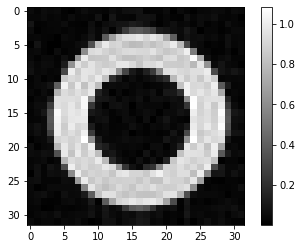

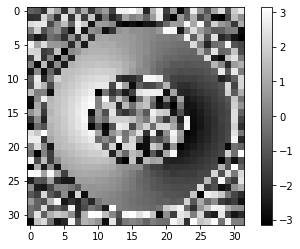

In [4]:
tt = 11

plt.figure()
plt.imshow(np.abs(all_im_pc[tt]), cmap='gray')
plt.colorbar()

plt.figure()
plt.imshow(np.angle(all_im_pc[tt]), cmap='gray')
plt.colorbar()

In [5]:
# Jupyter animation of image
import numpy as np
from torch_track.utils_anim import TagAnimator
from IPython.display import HTML

A = TagAnimator(np.squeeze(np.angle(all_im_pc)), None)
HTML(A.anim.to_jshtml())

Starting animation class . . . 
Making animation . . . 
